# やること

- 実機による学習(notebooks/note17.ipynb をベースに)
- 正解のパラメータでシミュレーションして比較する
- プロット数調整する
- GRU との調和も試したい


In [238]:
import sys

sys.path.append("..")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch import nn, optim

from src.utils.save_log import (
    create_result_dir,
    init_log,
    save_figure_to_log,
    save_text_output,
)

# 乱数固定用の処理
seed = 10
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

np.random.seed(seed)

In [239]:
path0 = "../data/csv/tek0000ALL.csv"
path1 = "../data/csv/tek0001ALL.csv"

data_path = path0

# 真値パラメータ（すべてのデータセットで共通）
L_true: float = 100e-6
C_true: float = 48e-6
R_true: float = 10

Vin = 10
Vref = 6
duty = Vref / Vin
f_sw = 1e5  # スイッチング周波数
T = 1 / f_sw  # 1周期の実時間

train_ratio = 0.3
valid_ratio = 0.3
# test_ratio = 1 - train_ratio - valid_ratio

# 学習パラメータ
L_init = 200e-6
C_init = 100e-6
R_init = 8.0

# 異なるパラメータに異なる学習率を設定
lr_L = 5e-2
lr_C = 1e-2
lr_R = 2e-2

epochs = 1000

keep_log = True  # 結果保存するかどうか


# 実機データの可視化


In [240]:
# 実機データのファイルのヘッダー確認
with open(path1, encoding="utf-8", errors="replace") as f:
    for i, line in enumerate(f, start=1):
        if i > 25:
            break
        print(f"{i:>5}: {line.rstrip()}")

    1: Model,MDO3024,
    2: Firmware Version,1.3,
    3: ,,
    4: Waveform Type,ANALOG,
    5: Point Format,Y,
    6: Horizontal Units,s,
    7: Horizontal Scale,0.0002,
    8: Horizontal Delay,0.000741,
    9: Sample Interval,2e-09,
   10: Record Length,1e+06,
   11: Gating,0.0% to 100.0%,
   12: Probe Attenuation,10,1
   13: Vertical Units,A,V
   14: Vertical Offset,0,0
   15: Vertical Scale,0.5,2
   16: Vertical Position,-2.82,0.04
   17: ,,
   18: ,,
   19: ,,
   20: Label,,
   21: TIME,CH1,CH2
   22: -2.59E-04,-0.09,-0.08
   23: -2.59E-04,-0.11,-0.08
   24: -2.59E-04,-0.11,-0.08
   25: -2.59E-04,-0.09,-0.08


In [241]:
df = pd.read_csv(path1, skiprows=20)

print(len(df))
df.head()

1000000


,TIME,CH1,CH2
0,-0.000259,-0.09,-0.08
1,-0.000259,-0.11,-0.08
2,-0.000259,-0.11,-0.08
3,-0.000259,-0.09,-0.08
4,-0.000259,-0.11,-0.16


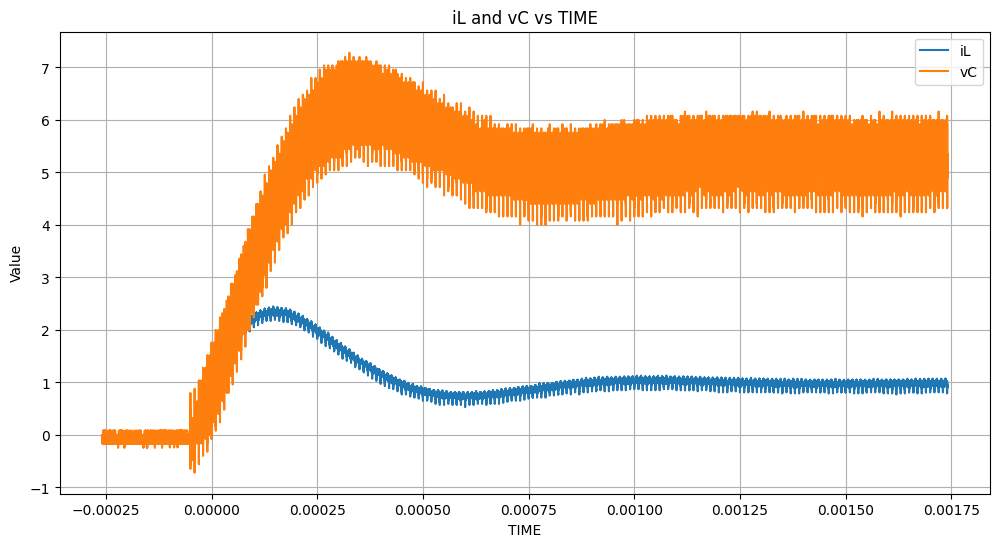

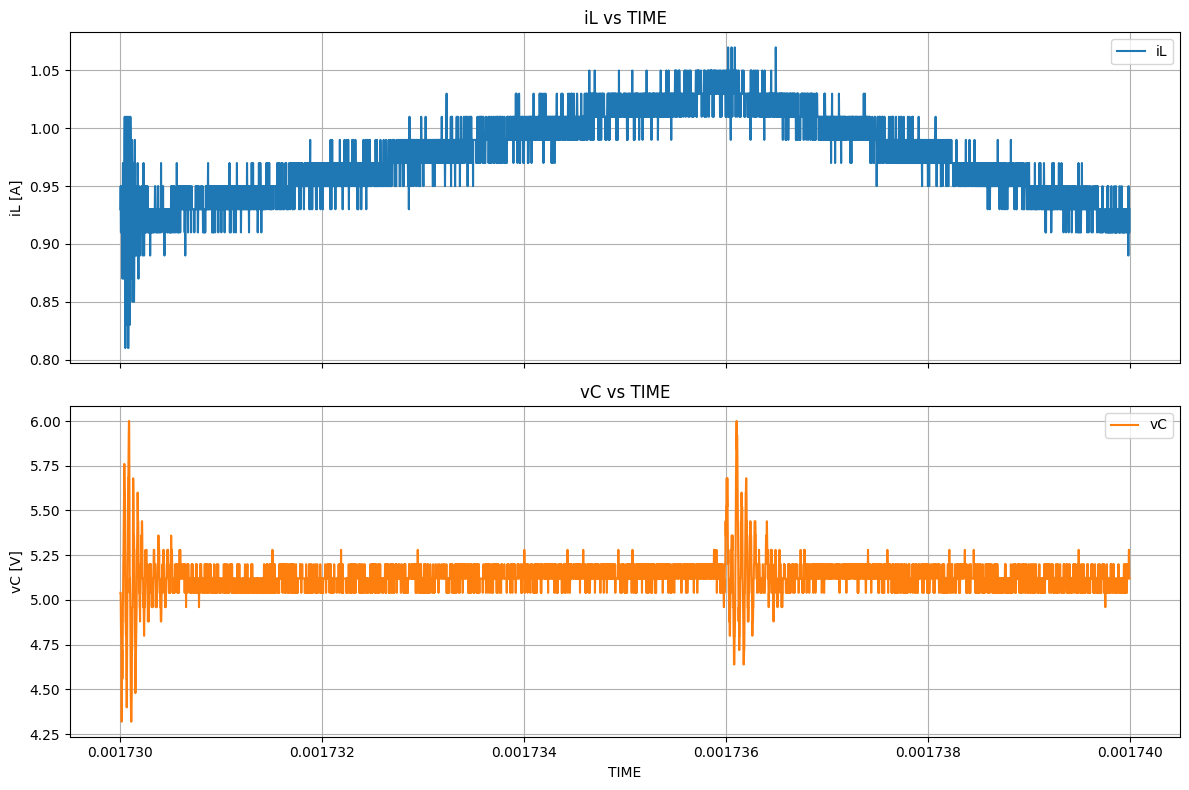

In [242]:
t_raw: np.ndarray = df["TIME"].to_numpy(dtype=np.float32)  # 秒
iL_raw: np.ndarray = df["CH1"].to_numpy(dtype=np.float32)  # A
vC_raw: np.ndarray = df["CH2"].to_numpy(dtype=np.float32)  # V


plt.figure(figsize=(12, 6))
plt.plot(t_raw, iL_raw, label="iL")
plt.plot(t_raw, vC_raw, label="vC")
plt.xlabel("TIME")
plt.ylabel("Value")
plt.title("iL and vC vs TIME")
plt.legend()
plt.grid(True)
plt.show()

# 1周期分の波形を表示
mask: np.ndarray = (0.00173 <= t_raw) & (t_raw <= 0.00174)
_t = t_raw[mask]
_iL = iL_raw[mask]
_vC = vC_raw[mask]
# TIME軸を共有して、iLとvCを上下2段でプロット
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# iLのプロット
axes[0].plot(_t, _iL, label="iL", color="tab:blue")
axes[0].set_ylabel("iL [A]")
axes[0].set_title("iL vs TIME")
axes[0].legend()
axes[0].grid(True)

# vCのプロット
axes[1].plot(_t, _vC, label="vC", color="tab:orange")
axes[1].set_xlabel("TIME")
axes[1].set_ylabel("vC [V]")
axes[1].set_title("vC vs TIME")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()
plt.show()

- シミュレーションの波形と大体同じだが、ノイズが大きい
- vC に関しては、ノイズを除けば　 5.00 ~ 5.25 だがノイズのところは 4.25 ~ 6.00 くらいまである
  - 元の値の 20% くらいノイズがのっちゃってる


# 前処理


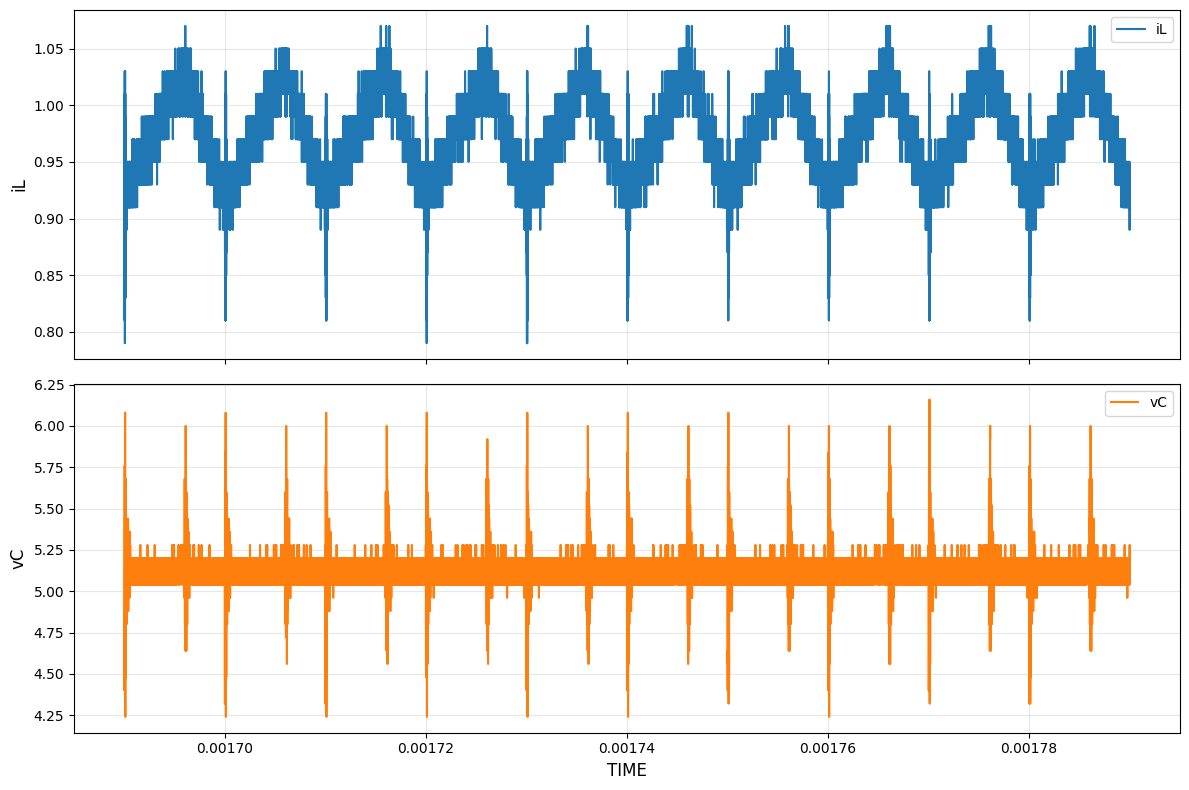

In [243]:
# Time 軸が -0.00005 から始まっているので、すべての時刻を +0.00005 し、0以上部分のみ抽出
t_all: np.ndarray = t_raw + 0.00005
mask: np.ndarray = t_all >= 0
t_all = t_all[mask]
iL_all = iL_raw[mask]
vC_all = vC_raw[mask]


# 定常状態っぽいところを10周期分だけ切り出す
start_t, end_t = 0.00169, 0.00179
mask: np.ndarray = (start_t <= t_all) & (t_all <= end_t)
t = t_all[mask]
iL = iL_all[mask]
vC = vC_all[mask]


# iL と vC を別々のグラフに描画
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# 上段: iL（上のセルの色に合わせる）
ax1.plot(t, iL, color="tab:blue", linewidth=1.5, label="iL")
ax1.set_ylabel("iL", fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.legend(loc="best")

# 下段: vC（上のセルの色に合わせる）
ax2.plot(t, vC, color="tab:orange", linewidth=1.5, label="vC")
ax2.set_ylabel("vC", fontsize=12)
ax2.set_xlabel("TIME", fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.legend(loc="best")

plt.tight_layout()
plt.show()


50001 -> 2001


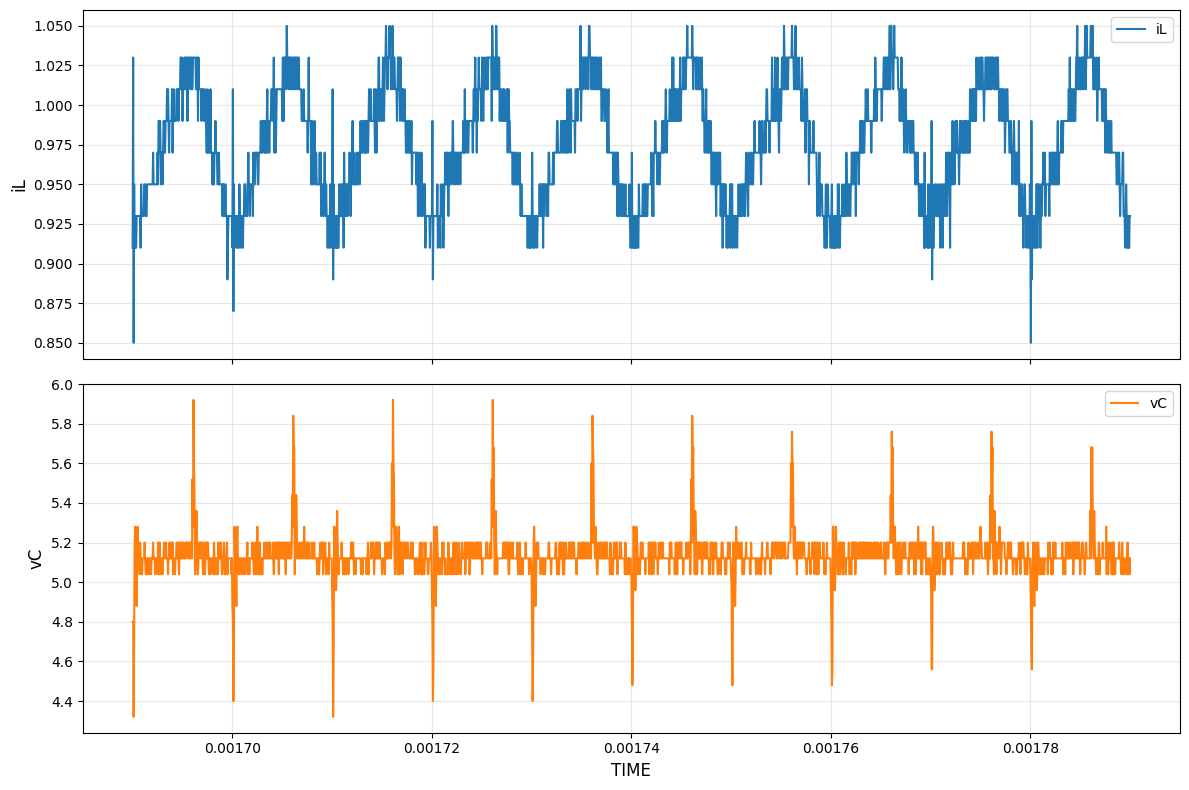

In [244]:
# プロット数を減らす
step = len(t) // 2000
t_downsampled = t[::step]
iL_downsampled = iL[::step]
vC_downsampled = vC[::step]

print(f"{len(t)} -> {len(t_downsampled)}")

# iL と vC を別々のグラフに描画
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# 上段: iL（上のセルの色に合わせる）
ax1.plot(t_downsampled, iL_downsampled, color="tab:blue", linewidth=1.5, label="iL")
ax1.set_ylabel("iL", fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.legend(loc="best")

# 下段: vC（上のセルの色に合わせる）
ax2.plot(t_downsampled, vC_downsampled, color="tab:orange", linewidth=1.5, label="vC")
ax2.set_ylabel("vC", fontsize=12)
ax2.set_xlabel("TIME", fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.legend(loc="best")

plt.tight_layout()
plt.show()


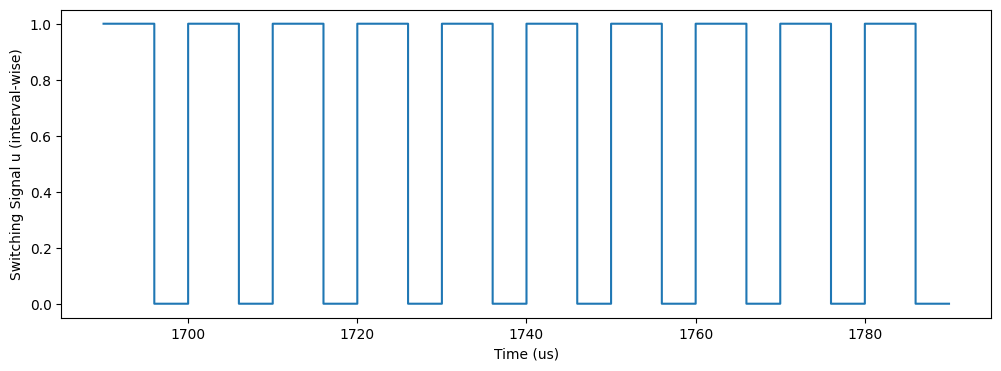

In [245]:
# スイッチング信号
duty_phase = (t_downsampled[:-1] % T) / T
u = (duty_phase < duty).astype(int)

# 入力電圧
vs = np.ones(len(t_downsampled) - 1) * Vin

# プロット
plt.figure(figsize=(12, 4))
plt.step(t_downsampled[:-1] * 1e6, u, where="post")
plt.xlabel("Time (us)")
plt.ylabel("Switching Signal u (interval-wise)")
plt.show()

In [246]:
# train, valid, test の分割
dt = t_downsampled[1:] - t_downsampled[:-1]

# numpy配列をテンソルに変換
dt_tensor = torch.tensor(dt, dtype=torch.float32)
u_tensor = torch.tensor(u, dtype=torch.float32)
vs_tensor = torch.tensor(vs, dtype=torch.float32)
iL_tensor = torch.tensor(iL_downsampled, dtype=torch.float32)
vC_tensor = torch.tensor(vC_downsampled, dtype=torch.float32)

# train
train_len = int(len(dt) * train_ratio)

t_train = t_downsampled[: train_len + 1]
dt_train = dt_tensor[:train_len]
u_train = u_tensor[:train_len]
vs_train = vs_tensor[:train_len]
iL_train = iL_tensor[: train_len + 1]
vC_train = vC_tensor[: train_len + 1]

h_train = torch.stack([iL_train[:-1], vC_train[:-1]], dim=1)
x_train = torch.stack([vs_train, u_train, dt_train], dim=1)
target_train = torch.stack([iL_train[1:], vC_train[1:]], dim=1)


# valid
valid_len = int(len(dt) * valid_ratio)

t_valid = t_downsampled[train_len : train_len + valid_len]
dt_valid = dt_tensor[train_len : train_len + valid_len]
u_valid = u_tensor[train_len : train_len + valid_len]
vs_valid = vs_tensor[train_len : train_len + valid_len]
iL_valid = iL_tensor[train_len : train_len + valid_len + 1]
vC_valid = vC_tensor[train_len : train_len + valid_len + 1]

h_valid = torch.stack([iL_valid[:-1], vC_valid[:-1]], dim=1)
x_valid = torch.stack([vs_valid, u_valid, dt_valid], dim=1)
target_valid = torch.stack([iL_valid[1:], vC_valid[1:]], dim=1)

# test
# t_test = t_downsampled[train_len + valid_len :]
# dt_test = dt_tensor[train_len + valid_len :]
# u_test = u_tensor[train_len + valid_len :]
# vs_test = vs_tensor[train_len + valid_len :]
# iL_test = iL_tensor[train_len + valid_len :]
# vC_test = vC_tensor[train_len + valid_len :]

# h_test = torch.stack([iL_test[:-1], vC_test[:-1]], dim=1)
# x_test = torch.stack([vs_test, u_test, dt_test], dim=1)
# target_test = torch.stack([iL_test[1:], vC_test[1:]], dim=1)


print(f"{h_train.shape=}")
print(f"{x_train.shape=}")
print(f"{target_train.shape=}")

print(f"{h_valid.shape=}")
print(f"{x_valid.shape=}")
print(f"{target_valid.shape=}")

# print(f"{h_test.shape=}")
# print(f"{x_test.shape=}")
# print(f"{target_test.shape=}")


h_train.shape=torch.Size([600, 2])
x_train.shape=torch.Size([600, 3])
target_train.shape=torch.Size([600, 2])
h_valid.shape=torch.Size([600, 2])
x_valid.shape=torch.Size([600, 3])
target_valid.shape=torch.Size([600, 2])


# モデル定義


In [247]:
class BuckConverterCell(nn.Module):
    def __init__(self, L_init: float, C_init: float, R_init: float) -> None:
        super().__init__()
        # パラメータを対数空間で学習（正の値を保証）
        self.log_L = nn.Parameter(torch.log(torch.tensor(L_init)))
        self.log_C = nn.Parameter(torch.log(torch.tensor(C_init)))
        self.log_R = nn.Parameter(torch.log(torch.tensor(R_init)))

    def forward(self, h: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
        """
        h: [iL, vC]
        x: [vs, u, dt]
        """

        iL = h[:, 0]
        vC = h[:, 1]
        vs = x[:, 0]
        u = x[:, 1]
        dt = x[:, 2]
        vp = vs * u

        # パラメータを指数関数で変換（正の値を保証）
        L = torch.exp(self.log_L)
        C = torch.exp(self.log_C)
        R = torch.exp(self.log_R)

        # オイラー法
        iL_next = iL + (dt / L) * (vp - vC)
        vC_next = vC + (dt / C) * (iL - vC / R)

        return torch.stack([iL_next, vC_next], dim=1)


# 学習


In [248]:
model = BuckConverterCell(L_init=L_init, C_init=C_init, R_init=R_init)

optimizer = optim.Adam(
    [
        {"params": [model.log_L], "lr": lr_L},
        {"params": [model.log_C], "lr": lr_C},
        {"params": [model.log_R], "lr": lr_R},
    ]
)

loss_fn = nn.MSELoss()

# 損失履歴を保存
loss_history = {"train": [], "valid": []}
param_history = {"L": [], "C": [], "R": []}

# 学習ループ
for epoch in range(epochs):
    # 学習モード
    model.train()
    optimizer.zero_grad()
    h_pred_train = model(h_train, x_train)
    train_loss = loss_fn(h_pred_train, target_train)
    train_loss.backward()
    optimizer.step()

    loss_history["train"].append(train_loss.item())

    # 検証モード（勾配計算なし）
    model.eval()
    with torch.no_grad():
        h_pred_valid = model(h_valid, x_valid)
        valid_loss = loss_fn(h_pred_valid, target_valid)
        loss_history["valid"].append(valid_loss.item())

    # パラメータの履歴を保存
    param_history["L"].append(model.log_L.exp().item())
    param_history["C"].append(model.log_C.exp().item())
    param_history["R"].append(model.log_R.exp().item())

    if epoch % 50 == 0:
        output_line = (
            f"Epoch {epoch}: Train Loss={train_loss.item():.6e}, "
            f"Valid Loss={valid_loss.item():.6e}  "
            f"L={model.log_L.exp().item() * 1e6:.1f}µH (true={L_true * 1e6:.1f})  "
            f"C={model.log_C.exp().item() * 1e6:.1f}µF (true={C_true * 1e6:.1f})  "
            f"R={model.log_R.exp().item():.2f}Ω (true={R_true:.1f})"
        )
        print(output_line)


Epoch 0: Train Loss=7.125621e-03, Valid Loss=6.665678e-03  L=210.0µH (true=100.0)  C=99.0µF (true=48.0)  R=7.85Ω (true=10.0)
Epoch 50: Train Loss=7.124406e-03, Valid Loss=6.664366e-03  L=281.7µH (true=100.0)  C=56.3µF (true=48.0)  R=2.70Ω (true=10.0)
Epoch 100: Train Loss=7.123560e-03, Valid Loss=6.663469e-03  L=276.0µH (true=100.0)  C=30.8µF (true=48.0)  R=3.07Ω (true=10.0)
Epoch 150: Train Loss=7.121365e-03, Valid Loss=6.661130e-03  L=276.4µH (true=100.0)  C=13.7µF (true=48.0)  R=4.02Ω (true=10.0)
Epoch 200: Train Loss=7.114261e-03, Valid Loss=6.653526e-03  L=276.4µH (true=100.0)  C=4.9µF (true=48.0)  R=4.75Ω (true=10.0)
Epoch 250: Train Loss=7.087585e-03, Valid Loss=6.624888e-03  L=276.4µH (true=100.0)  C=1.4µF (true=48.0)  R=5.07Ω (true=10.0)
Epoch 300: Train Loss=6.979821e-03, Valid Loss=6.509033e-03  L=276.4µH (true=100.0)  C=0.3µF (true=48.0)  R=5.22Ω (true=10.0)
Epoch 350: Train Loss=6.691656e-03, Valid Loss=6.199794e-03  L=276.4µH (true=100.0)  C=0.1µF (true=48.0)  R=5.26Ω (tr

# 検証


In [249]:
# テストデータでの評価
model.eval()
with torch.no_grad():
    h_pred_test = model(h_test, x_test)
    test_loss = loss_fn(h_pred_test, target_test)

print(f"Final test loss: {test_loss.item():.6e}")


Final test loss: 5.563519e-03


# 結果


In [250]:
# 結果保存設定
config_dict = {
    "data_path": data_path,
    "start_time": start_t,
    "end_time": end_t,
    "steps": len(t_downsampled),
    "L_true": L_true,
    "C_true": C_true,
    "R_true": R_true,
    "Vin": Vin,
    "Vref": Vref,
    "f_sw": f_sw,
    "L_init": L_init,
    "C_init": C_init,
    "R_init": R_init,
    "lr_L": lr_L,
    "lr_C": lr_C,
    "lr_R": lr_R,
    "epochs": epochs,
}


if keep_log:
    # ログ保存の初期化
    result_dir = create_result_dir(
        "note1",
        base_dir="results/actual",
        config_dict=config_dict,
    )
    log_path = init_log(result_dir, "actual_machine_notebooks/note1.ipynb")
    print(f"ログ保存先: {result_dir}/log.md")

ログ保存先: /Users/otsukanaoya/Desktop/unilab/rnn-pann/results/actual/20251204_183025_640_note1/log.md


In [251]:
final_train_loss = loss_history["train"][-1]
final_valid_loss = loss_history["valid"][-1]
final_test_loss = test_loss.item()

final_L = param_history["L"][-1]
final_C = param_history["C"][-1]
final_R = param_history["R"][-1]

# 実験設定の表示
result_text = []
result_text.append("=" * 60)
result_text.append("")
result_text.append("【回路パラメータ】")
result_text.append(
    f"  真の値: L = {L_true:.6e} [H], C = {C_true:.6e} [F], R = {R_true:.3f} [Ω]"
)
result_text.append(
    f"  初期値: L = {L_init:.6e} [H], C = {C_init:.6e} [F], R = {R_init:.3f} [Ω]"
)
result_text.append(
    f"  推論値: L = {final_L:.6e} [H], C = {final_C:.6e} [F], R = {final_R:.3f} [Ω]"
)
result_text.append("")
result_text.append("【入力条件】")
result_text.append(
    f"  Vin (入力電圧) = {Vin:.2f} [V], Vref (目標電圧) = {Vref:.2f} [V]"
)
result_text.append(f"  スイッチング周波数 f_sw = {f_sw:.0f} [Hz]")
result_text.append(f"  プロット数 = {len(t_downsampled)}")
result_text.append("")
result_text.append("【データ分割】")
result_text.append(f"  シミュレーション時間: {(end_t - start_t) * 1e6:.1f}μs")
result_text.append(f"  {start_t * 1e6:.1f}μs ~ {end_t * 1e6:.1f}μs")
result_text.append(f"  {len(t_downsampled)}ステップ")
result_text.append(f"  学習データ: {train_len} ステップ")
result_text.append(f"  検証データ: {valid_len} ステップ")
result_text.append(
    f"  テストデータ: {len(t_downsampled) - train_len - valid_len} ステップ"
)
result_text.append("")
result_text.append("【最終Loss】")
result_text.append(f"  学習データ: {final_train_loss:.6e}")
result_text.append(f"  検証データ: {final_valid_loss:.6e}")
result_text.append(f"  テストデータ: {final_test_loss:.6e}")
result_text.append("")
result_text.append("【学習設定】")
result_text.append(f"  エポック数: {epochs}")
result_text.append(f"  学習率: L = {lr_L:.2e}, C = {lr_C:.2e}, R = {lr_R:.2e}")

result_output = "\n".join(result_text)
print(result_output)

# 結果をログに保存
if keep_log:
    save_text_output(result_dir, result_output, "最終結果")



【回路パラメータ】
  真の値: L = 1.000000e-04 [H], C = 4.800000e-05 [F], R = 10.000 [Ω]
  初期値: L = 2.000000e-04 [H], C = 1.000000e-04 [F], R = 8.000 [Ω]
  推論値: L = 2.763907e-04 [H], C = 5.762465e-08 [F], R = 5.260 [Ω]

【入力条件】
  Vin (入力電圧) = 10.00 [V], Vref (目標電圧) = 6.00 [V]
  スイッチング周波数 f_sw = 100000 [Hz]
  プロット数 = 2001

【データ分割】
  シミュレーション時間: 100.0μs
  1690.0μs ~ 1790.0μs
  2001ステップ
  学習データ: 600 ステップ
  検証データ: 600 ステップ
  テストデータ: 801 ステップ

【最終Loss】
  学習データ: 6.644800e-03
  検証データ: 6.151487e-03
  テストデータ: 5.563519e-03

【学習設定】
  エポック数: 1000
  学習率: L = 5.00e-02, C = 1.00e-02, R = 2.00e-02


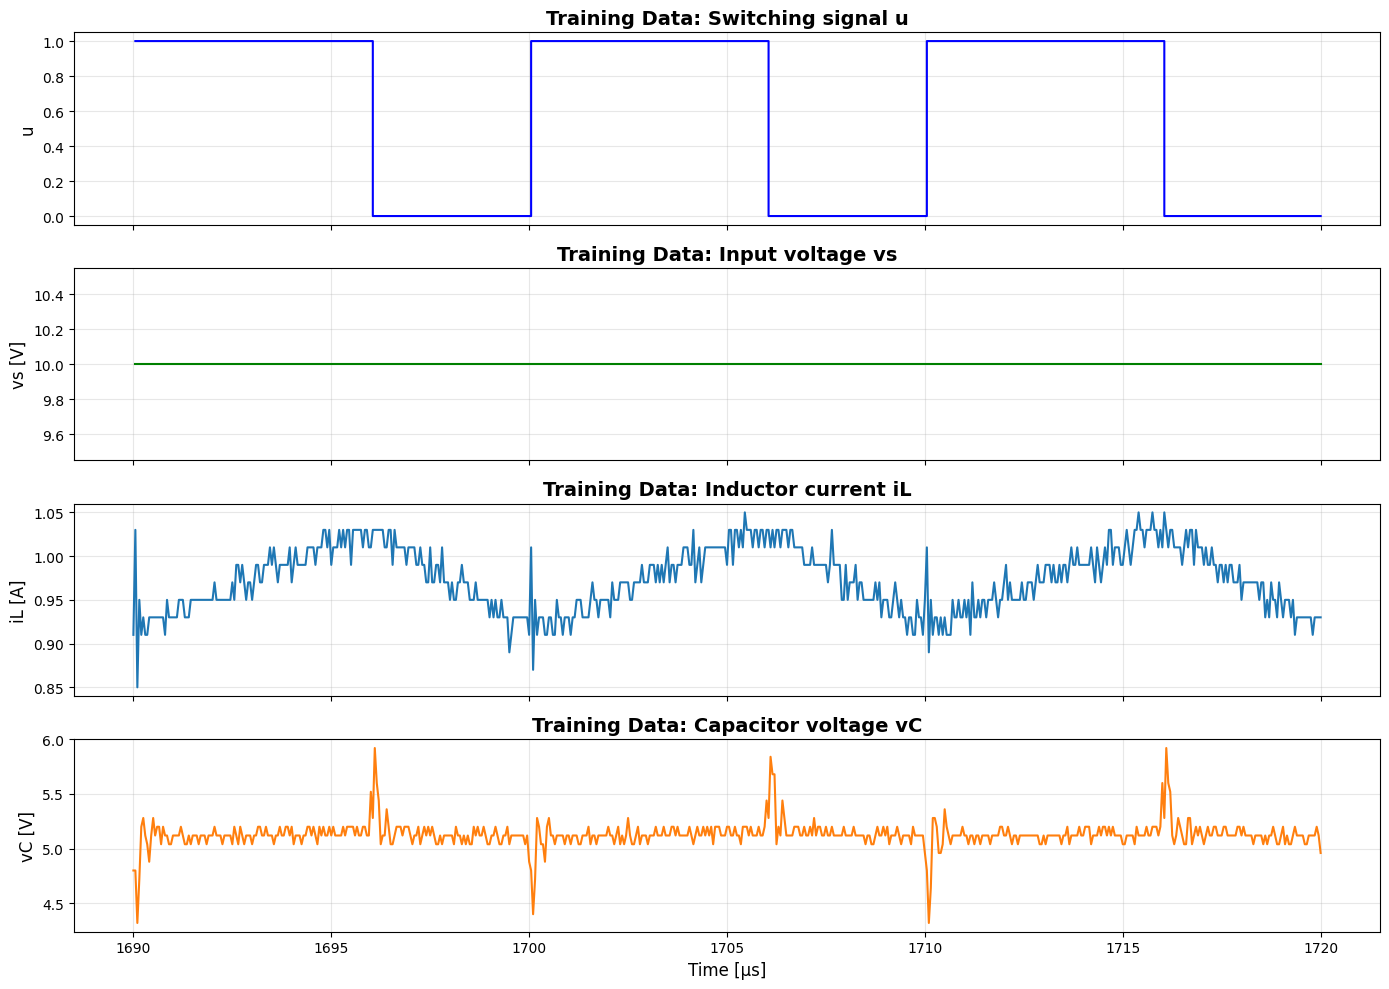

In [252]:
# 学習に使ったデータ
fig, axs = plt.subplots(4, 1, figsize=(14, 10), sharex=True)

# 1: u (switching signal)
axs[0].step(t_train[1:] * 1e6, u_train, where="post", color="blue", linewidth=1.5)
axs[0].set_ylabel("u", fontsize=12)
axs[0].grid(True, alpha=0.3)
axs[0].set_title("Training Data: Switching signal u", fontsize=14, fontweight="bold")

# 2: vs (input voltage)
axs[1].plot(t_train[1:] * 1e6, vs_train, color="green", linewidth=1.5)
axs[1].set_ylabel("vs [V]", fontsize=12)
axs[1].grid(True, alpha=0.3)
axs[1].set_title("Training Data: Input voltage vs", fontsize=14, fontweight="bold")

# 3: iL (inductor current)
axs[2].plot(t_train * 1e6, iL_train, color="tab:blue", linewidth=1.5)
axs[2].set_ylabel("iL [A]", fontsize=12)
axs[2].grid(True, alpha=0.3)
axs[2].set_title("Training Data: Inductor current iL", fontsize=14, fontweight="bold")

# 4: vC (capacitor voltage)
axs[3].plot(t_train * 1e6, vC_train, color="tab:orange", linewidth=1.5)
axs[3].set_ylabel("vC [V]", fontsize=12)
axs[3].set_xlabel("Time [μs]", fontsize=12)
axs[3].grid(True, alpha=0.3)
axs[3].set_title("Training Data: Capacitor voltage vC", fontsize=14, fontweight="bold")

plt.tight_layout()
plt.show()

# 画像をログに保存
if keep_log:
    save_figure_to_log(fig, "training_data", result_dir, "学習データ")


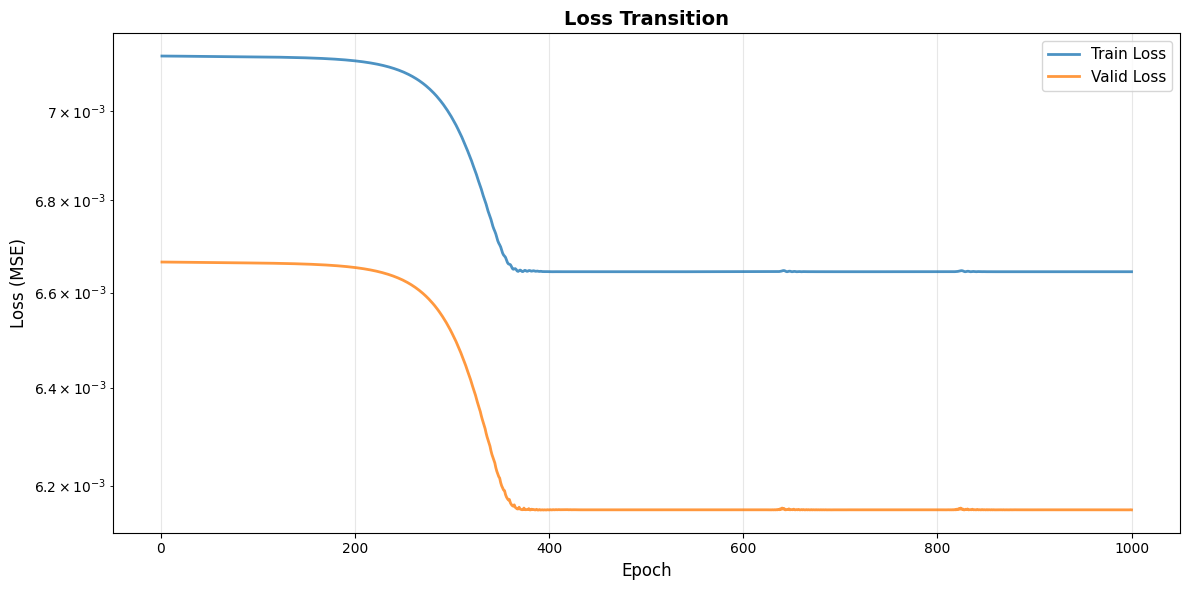

In [253]:
# Lossの遷移をグラフ表示
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

epochs_list = range(1, epochs + 1)
ax.plot(epochs_list, loss_history["train"], label="Train Loss", linewidth=2, alpha=0.8)
ax.plot(epochs_list, loss_history["valid"], label="Valid Loss", linewidth=2, alpha=0.8)

ax.set_xlabel("Epoch", fontsize=12)
ax.set_ylabel("Loss (MSE)", fontsize=12)
ax.set_title("Loss Transition", fontsize=14, fontweight="bold")
ax.set_yscale("log")
ax.grid(True, alpha=0.3)
ax.legend(fontsize=11)

plt.tight_layout()
plt.show()

# 画像をログに保存
if keep_log:
    save_figure_to_log(fig, "loss_transition", result_dir, "Lossの遷移")


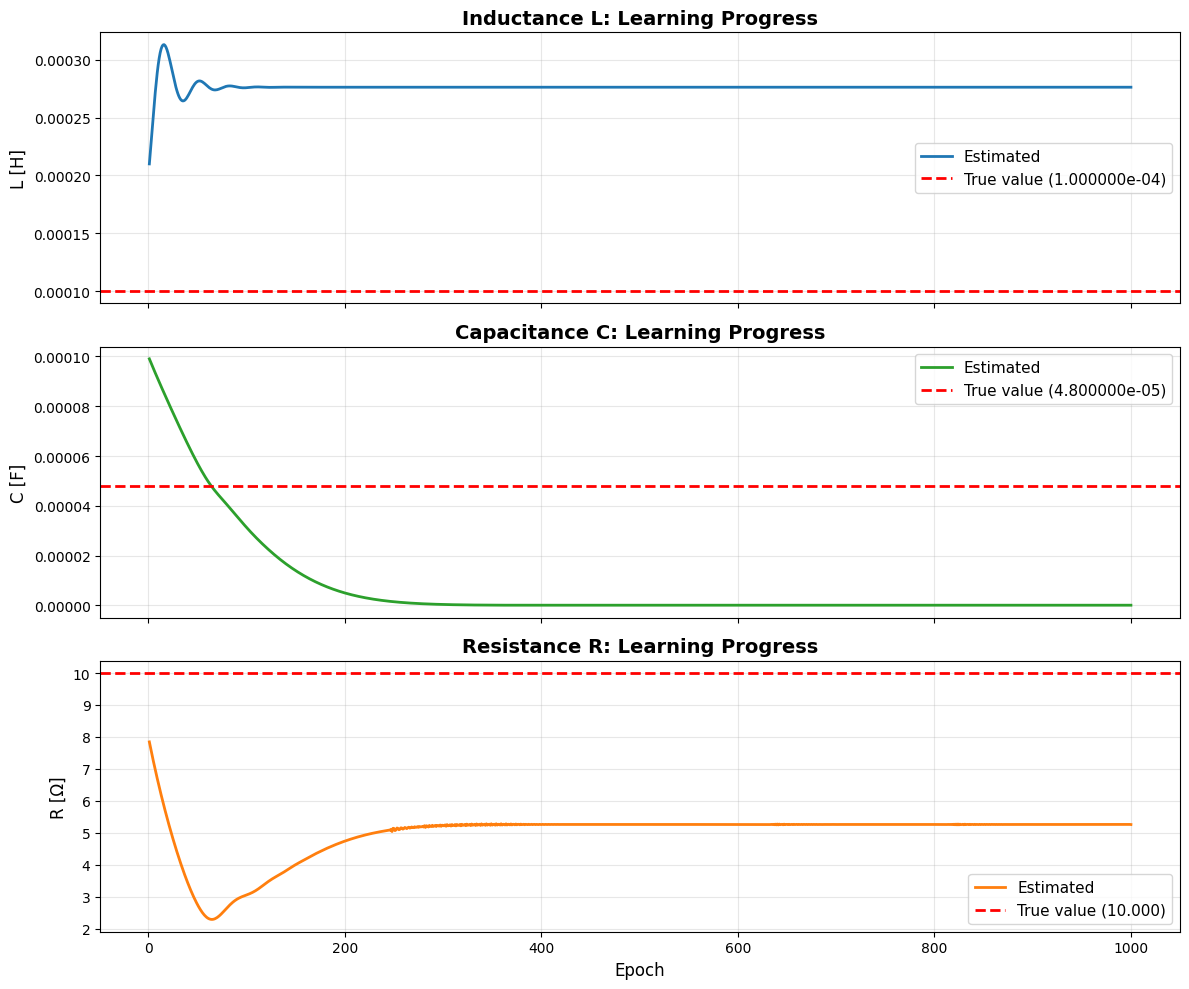

In [254]:
# 回路パラメータの学習による変化をグラフ表示
fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

epochs_list = range(1, epochs + 1)

# Lの変化
axs[0].plot(
    epochs_list, param_history["L"], label="Estimated", linewidth=2, color="tab:blue"
)
axs[0].axhline(
    y=L_true,
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"True value ({L_true:.6e})",
)
axs[0].set_ylabel("L [H]", fontsize=12)
axs[0].set_title("Inductance L: Learning Progress", fontsize=14, fontweight="bold")
axs[0].grid(True, alpha=0.3)
axs[0].legend(fontsize=11)

# Cの変化
axs[1].plot(
    epochs_list, param_history["C"], label="Estimated", linewidth=2, color="tab:green"
)
axs[1].axhline(
    y=C_true,
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"True value ({C_true:.6e})",
)
axs[1].set_ylabel("C [F]", fontsize=12)
axs[1].set_title("Capacitance C: Learning Progress", fontsize=14, fontweight="bold")
axs[1].grid(True, alpha=0.3)
axs[1].legend(fontsize=11)

# Rの変化
axs[2].plot(
    epochs_list, param_history["R"], label="Estimated", linewidth=2, color="tab:orange"
)
axs[2].axhline(
    y=R_true,
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"True value ({R_true:.3f})",
)
axs[2].set_ylabel("R [Ω]", fontsize=12)
axs[2].set_xlabel("Epoch", fontsize=12)
axs[2].set_title("Resistance R: Learning Progress", fontsize=14, fontweight="bold")
axs[2].grid(True, alpha=0.3)
axs[2].legend(fontsize=11)

plt.tight_layout()
plt.show()

# 画像をログに保存
if keep_log:
    save_figure_to_log(
        fig, "parameter_learning", result_dir, "回路パラメータの学習による変化"
    )


In [255]:
dt_sim: np.ndarray = np.diff(t_all)

# スイッチング信号
duty_phase = (t_all[:-1] % T) / T
u_sim = (duty_phase < duty).astype(int)

# 入力電圧
vs_sim = np.ones(len(t_all) - 1) * Vin

x_sim = torch.tensor(
    np.c_[vs_sim, u_sim, dt_sim],
    dtype=torch.float32,
)

# シミュレーションして検証
iL_list = []
vC_list = []

model.eval()
with torch.no_grad():
    h_current = torch.zeros(1, 2)
    iL_list.append(h_current[0, 0].item())
    vC_list.append(h_current[0, 1].item())
    for j in range(len(t_all) - 1):
        h_current = model(h_current, x_sim[j : j + 1])
        iL_list.append(h_current[0, 0].item())
        vC_list.append(h_current[0, 1].item())


# 予測値（iL, vC）
iL_pred = torch.tensor(iL_list)
vC_pred = torch.tensor(vC_list)

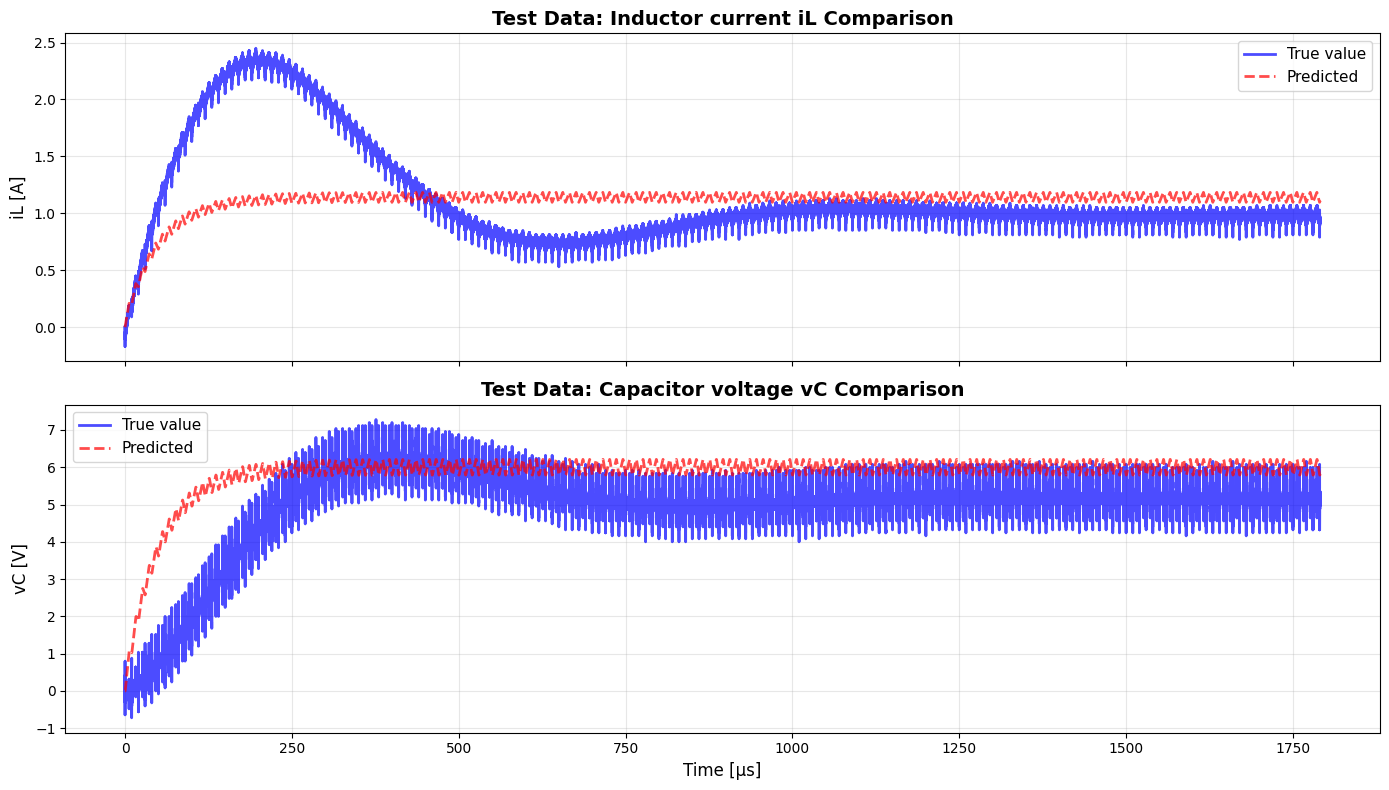

In [256]:
# グラフ表示
fig, axs = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# iLの比較
axs[0].plot(
    t_all * 1e6,
    iL_all,
    label="True value",
    linewidth=2,
    alpha=0.7,
    color="blue",
)
axs[0].plot(
    t_all * 1e6,
    iL_pred,
    label="Predicted",
    linewidth=2,
    alpha=0.7,
    color="red",
    linestyle="--",
)
axs[0].set_ylabel("iL [A]", fontsize=12)
axs[0].set_title(
    "Test Data: Inductor current iL Comparison", fontsize=14, fontweight="bold"
)
axs[0].grid(True, alpha=0.3)
axs[0].legend(fontsize=11)

# vCの比較
axs[1].plot(
    t_all * 1e6,
    vC_all,
    label="True value",
    linewidth=2,
    alpha=0.7,
    color="blue",
)
axs[1].plot(
    t_all * 1e6,
    vC_pred,
    label="Predicted",
    linewidth=2,
    alpha=0.7,
    color="red",
    linestyle="--",
)
axs[1].set_ylabel("vC [V]", fontsize=12)
axs[1].set_xlabel("Time [μs]", fontsize=12)
axs[1].set_title(
    "Test Data: Capacitor voltage vC Comparison", fontsize=14, fontweight="bold"
)
axs[1].grid(True, alpha=0.3)
axs[1].legend(fontsize=11)

plt.tight_layout()
plt.show()

# 画像をログに保存
if keep_log:
    save_figure_to_log(
        fig,
        "test_prediction",
        result_dir,
        "学習済みモデルでの予測結果",
    )


# まとめ

- なんか上手くいってはないが、一応実行はできた
- notebooks/note17.ipynb のモデルをベースに、それ以外の設定は notebooks/note13.ipynb の設定をそのまま使った
- このノートブックの特別な実装は、プロット数を下げたこと
  - note13 では、学習するときに C の値が小さくなるすぎて、それによって出力が大きくなってしまい inf で発散してしまった

### 仮説

- プロット数が 1 周期あたり、5000→200 に落としたこと
  - 実機データはスイッチング時に大きなノイズが出る(20%くらい)。しかし、スイッチング時なので、1 周期あたり 2 回だけ
  - それ以外は小さいノイズはあるものの、小さい
  - そのため、5000 点だとノイズの影響が大きく出てしまう
  - 200 点だと、ノイズの影響が小さくなり、学習が安定する
